# Exercise 6: CNN with SGD, MC Dropout, and Epistemic Uncertainty

Train a controlled convolutional neural network (CNN) on a subset of the SVHN dataset using SGD optimizer. Then, apply Monte Carlo (MC) Dropout at inference to estimate both test accuracy and epistemic uncertainty. Set random seeds to 42. Use the following configuration:
- Load SVHN and normalize pixel values to [0,1]
- Use only the first 2000 training samples and first 500 test samples
- Input shape: 32 × 32 × 3
- CNN architecture:
  - Conv2D: 32 filters, 3×3 kernel, ReLU activation
  - MaxPooling2D: 2×2
  - Conv2D: 64 filters, 3×3 kernel, ReLU activation
  - MaxPooling2D: 2×2
  - Flatten
  - Dense: 128 neurons, ReLU activation
  - Dropout: 0.25 (keep during inference for MC Dropout)
  - Output layer: 10 neurons with softmax
- Optimizer: SGD with momentum = 0.9, learning rate = 0.01
- Loss: sparse categorical crossentropy
- epochs = 15, batch size = 32
- For MC Dropout:
  - Enable dropout during inference
  - Average predictions over 20 stochastic forward passes
  - Compute the epistemic uncertainty as the predictive variance across passes

Q6.1 Report the plain test accuracy of the CNN trained with SGD (no MC Dropout).

Q6.2 Report the MC Dropout-enhanced accuracy (averaging 20 stochastic predictions).

Q6.3 Compute the average epistemic uncertainty (mean predictive variance) across all test samples. Report it as a deterministic number rounded to 3 decimal places.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Load SVHN (format 2)
import tensorflow_datasets as tfds

(tf_train, tf_test), info = tfds.load(
    "svhn_cropped",
    split=["train[:2000]", "test[:500]"],
    as_supervised=True,
    with_info=True
)

X_train = tf.convert_to_tensor([x.numpy() / 255.0 for x, _ in tf_train])
y_train = tf.convert_to_tensor([y.numpy() for _, y in tf_train])

X_test = tf.convert_to_tensor([x.numpy() / 255.0 for x, _ in tf_test])
y_test = tf.convert_to_tensor([y.numpy() for _, y in tf_test])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.PGXLQO_3.1.0/svhn_cropped-train.tfrecord*...:   0%…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.PGXLQO_3.1.0/svhn_cropped-test.tfrecord*...:   0%|…

Generating extra examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.PGXLQO_3.1.0/svhn_cropped-extra.tfrecord*...:   0%…

Dataset svhn_cropped downloaded and prepared to /root/tensorflow_datasets/svhn_cropped/3.1.0. Subsequent calls will reuse this data.


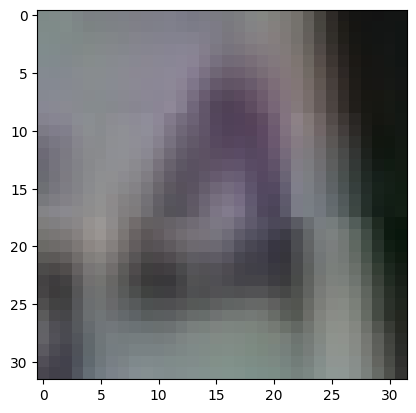

In [3]:
# Plot an instance
plt.imshow(X_train[0])
plt.show()

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# 🚀 Train the CNN
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.1679 - loss: 2.2811 - val_accuracy: 0.2200 - val_loss: 2.2147
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.1714 - loss: 2.2624 - val_accuracy: 0.2200 - val_loss: 2.2111
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.1752 - loss: 2.2605 - val_accuracy: 0.2200 - val_loss: 2.2063
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.1745 - loss: 2.2596 - val_accuracy: 0.2200 - val_loss: 2.2057
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.1752 - loss: 2.2539 - val_accuracy: 0.2200 - val_loss: 2.1993
Epoch 6/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.1774 - loss: 2.2472 - val_accuracy: 0.2200 - val_loss: 2.1906
Epoch 7/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.1885 - loss: 2.2287 - val_accuracy: 0.2200 - val_loss: 2.1710
Epoch 8/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.1982 - loss: 2.2040 - val_accuracy: 0.2350 - v

In [8]:
# 🎯 Q6.1 — Plain test accuracy (no MC Dropout)
plain_loss, plain_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Q6.1 Plain test accuracy: {plain_acc:.4f}")

Q6.1 Plain test accuracy: 0.6420


In [9]:
# 🔁 Q6.2 — MC Dropout enhanced accuracy (20 stochastic passes)

from sklearn.metrics import accuracy_score

T = 20
preds = np.stack([model(X_test, training=True).numpy() for _ in range(T)], axis=0)
avg_preds = preds.mean(axis=0)
y_pred_mc = np.argmax(avg_preds, axis=1)

mc_acc = accuracy_score(y_test, y_pred_mc)
print(f"Q6.2 MC Dropout accuracy (T={T}): {mc_acc:.4f}")

Q6.2 MC Dropout accuracy (T=20): 0.6400


In [10]:
# 📊 Q6.3 — Epistemic uncertainty (mean predictive variance)
var_across = preds.var(axis=0)         # (n_test, 10)
per_sample_var = var_across.mean(1)    # variance per sample (mean over classes)
avg_uncertainty = float(per_sample_var.mean())
print(f"Q6.3 Average epistemic uncertainty (mean predictive variance): {avg_uncertainty:.3f}")

Q6.3 Average epistemic uncertainty (mean predictive variance): 0.004


In [11]:
# 📋 Summary of results
results = {
    "Plain test accuracy": round(float(plain_acc), 4),
    "MC Dropout accuracy": round(float(mc_acc), 4),
    "Avg epistemic uncertainty": round(avg_uncertainty, 3)
}
results

{'Plain test accuracy': 0.642,
 'MC Dropout accuracy': 0.64,
 'Avg epistemic uncertainty': 0.004}